[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tee-lab/PyDaddy/blob/master/notebooks/6%20-%20Recovering%20SDEs%20from%20simulated%20time%20series.ipynb)

# Recovering equations from a simulated time series

In this notebook, we will generate a simulated time series with a given SDE, and use PyDaddy to estimate the drift and diffusion functions from the simulated time series.

In [1]:
# Uncomment this cell if you are running this notebook on Colab or Binder.

# !pip install git+https://github.com/tee-lab/PyDaddy.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pydaddy
import sdeint

## Generate a simulated time series using `sdeint`

We will use the `sdeint` package to simulate a time series with specified drift and diffusion functions. The following cell contains some sample drift and diffusion functions. Uncomment a function of your choice, or define your own functions `f()` and `g()`.

In [3]:
# Linear drift and constant diffusion (OU process)
# def f(x):
#     return -x

# def g(x):
#     return np.sqrt(2)

# Cubic drift and quadratic diffusion
def f(x):
    return x - x ** 3

def g(x):
    return 2 - x ** 2

Visualize the drift and diffusion functions. Note that the diffusion function $g^2(x)$ is plotted instead of $g(x)$; since that is what we will estimate from the time series using PyDaddy.

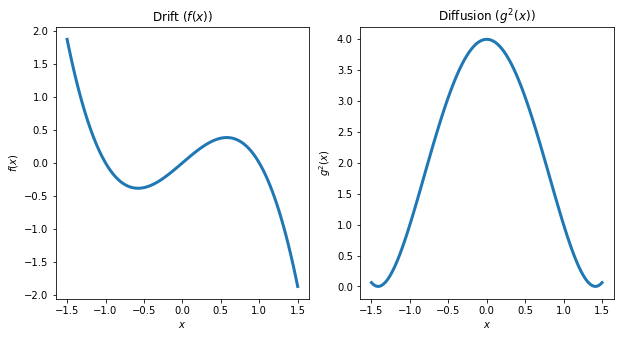

In [4]:
# Range of x over which to plot: edit as appropriate.
xs = np.linspace(-1.5, 1.5, 100)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(xs, f(xs), lw=3)
ax[1].plot(xs, g(xs) ** 2, lw=3)
ax[0].set(xlabel='$x$', ylabel='$f(x)$', title='Drift ($f(x)$)')
ax[1].set(xlabel='$x$', ylabel='$g^2(x)$', title='Diffusion ($g^2(x)$)')
plt.show()

In [5]:
dt = 0.01            # Integration time-step
timepoints = 100000  # Number of time-points to simulate
t = np.arange(0, dt * timepoints, step=dt)
x0 = 0.0             # Initial condition

# Simulate a time series with the given drift and diffusion functions, and given parameters.
x = sdeint.itoEuler(f=lambda x, t: f(x),
                    G=lambda x, t: g(x),
                    y0=x0, tspan=t)

Visualize the simulated time series to make sure that the simulation hasn't diverged, and has sufficiently explored the state space.

The first plot shows a sample (first 1000 points) from the time series, and the second plot shows the probability density histogram of the simulated time series.

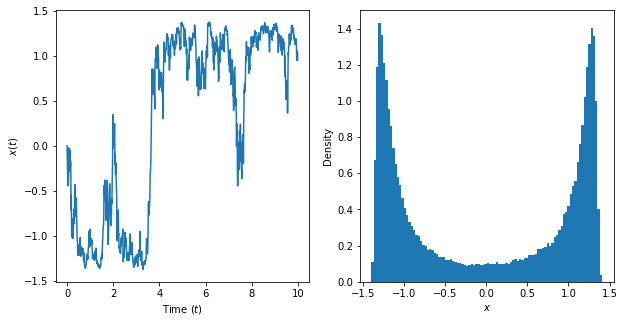

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(t[:1000], x[:1000])
ax[1].hist(x, bins=100, density=True)
ax[0].set(xlabel='Time ($t$)', ylabel='$x(t)$')
ax[1].set(xlabel='$x$', ylabel='Density')
plt.show()

## Recover drift and diffusion functions

We now use PyDaddy to recover to drift from the simulated time series.

| M range              : (-1.399, 1.409)|
| M mean               :     -0.003     |
| |M| range            :  (0.0, 1.409)  |
| |M| mean             :      1.02      |
| Autocorr time (M)    :       308      |
| (Dt, dt)             :     (1, 1)     |



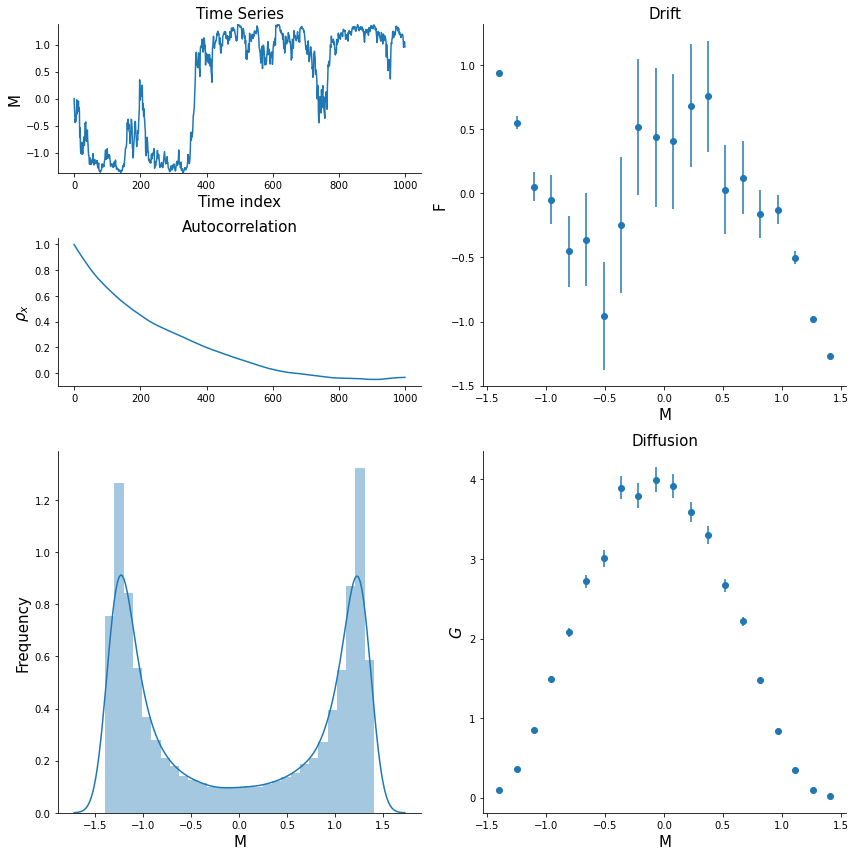

In [7]:
ddsde = pydaddy.Characterize([x], t, bins=20)

In [8]:
F = ddsde.fit('F', order=3, tune=True)
F

(0.861 ± 0.119)x + (-0.927 ± 0.082)x^3

In [9]:
G = ddsde.fit('G', order=4, tune=True)
G

(3.406 ± 0.022) + (-2.072 ± 0.052)x^2

**Note:** Automatic model selection may not always work, in which case some fine-tuning may be required. See the [Advanced Function Fitting](./3%20-%20Advanced%20Function%20Fitting.ipynb) notebook for more details.

In [10]:
G = ddsde.fit('G', order=4, threshold=0.1)
G

(3.978 ± 0.022) + (-3.948 ± 0.052)x^2 + (0.979 ± 0.026)x^4

Plot the estimated drift and diffusion function alongside the ground-truth drift and diffusion for comparison.

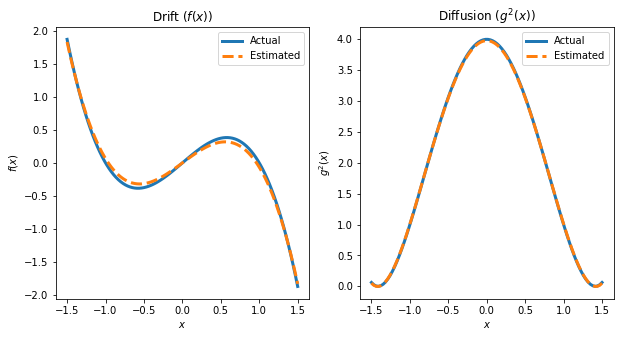

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(xs, f(xs), lw=3, label='Actual')
ax[0].plot(xs, F(xs), '--', lw=3, label='Estimated')
ax[1].plot(xs, g(xs) ** 2, lw=3, label='Actual')
ax[1].plot(xs, G(xs), '--', lw=3, label='Estimated')
ax[0].set(xlabel='$x$', ylabel='$f(x)$', title='Drift ($f(x)$)')
ax[1].set(xlabel='$x$', ylabel='$g^2(x)$', title='Diffusion ($g^2(x)$)')
ax[0].legend()
ax[1].legend()
plt.show()